# [George McNinch](http://gmcninch.math.tufts.edu) Math 87 - Spring 2026

# Integer programming via Branch & Bound
# Week 6


Integer programming: summary of some issue(s)
---------------------------------------------


As an example, consider the linear program:

``maximize`` $f(x_1,x_2) = x_1 + 5x_2$; i.e. $\mathbf{c} \cdot \mathbf{x}$ where $\mathbf{c} = \begin{bmatrix} 1 & 5 \end{bmatrix}$.

such that $A \mathbf{x} = \begin{bmatrix} 1 & 10 \\ 1 & 0 \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} \le
\begin{bmatrix} 20 \\ 2 \end{bmatrix}$ and $\mathbf{x} \ge \mathbf{0}$.

Let's find the optimal solution $\mathbf{x} \in \mathbb{R}^2$, and the optimal *integral* solution
$\mathbf{x}$ with $x_1,x_2 \in \mathbb{Z}$.

We'll start by solving the *relaxed* problem, where the integrality condition is ignored:

In [1]:
from scipy.optimize import linprog
import numpy as np

A = np.array([[1,10],[1,0]])
b = np.array([20,2])
c = np.array([1,5])

result=linprog((-1)*c,A_ub = A, b_ub = b)
print(f"result = {result.x}\nmaxvalue = {(-1)*result.fun:.2f}")

result = [2.  1.8]
maxvalue = 11.00


This calculution shows that an optimal solution with no integer constraint is $\mathbf{x} = \begin{bmatrix} 2 \\ 1.8 \end{bmatrix}$ and that the optimal value is roughly 11.


Let's make an image of the feasible set:

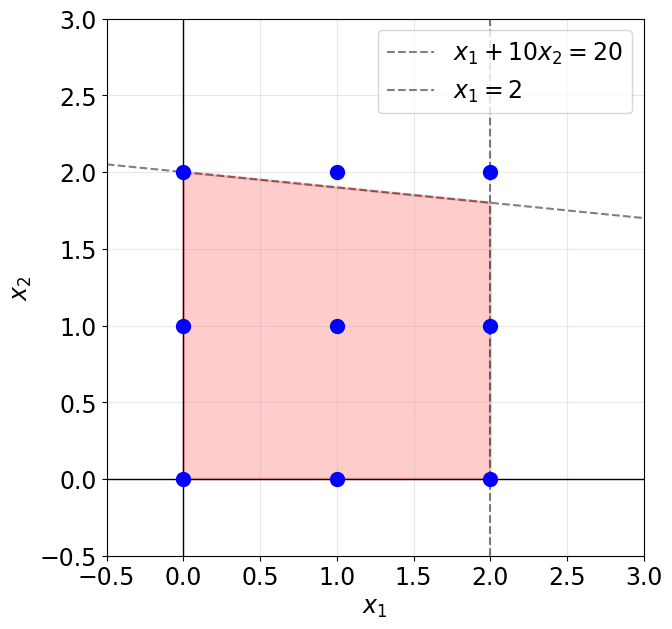

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon

plt.rcParams.update({'font.size': 17})

# Find the vertices of the feasible region
# For the constraints: x1 + 10x2 <= 20, x1 <= 2, x1 >= 0, x2 >= 0

# Find intersection points
vertices = []

# Origin
vertices.append([0, 0])

# x1-axis intercept of first constraint: x1 + 10(0) = 20 -> (2, 0) but x1 <= 2
vertices.append([2, 0])

# Intersection of x1 = 2 and x1 + 10x2 = 20: 2 + 10x2 = 20 -> (2, 1.8)
vertices.append([2, 1.8])

# x2-axis intercept of first constraint: 0 + 10x2 = 20 -> (0, 2)
vertices.append([0, 2])

# Create the plot
fig, ax = plt.subplots(figsize=(7, 7))

# Draw the feasible region
polygon = Polygon(vertices, alpha=0.2, facecolor='red', 
                  edgecolor='red', linewidth=2)
ax.add_patch(polygon)

# Draw axes
ax.axhline(y=0, color="black", linewidth=1)
ax.axvline(x=0, color="black", linewidth=1)

# Draw constraint lines (optional, for clarity)
x = np.linspace(-0.5, 3, 100)
# x1 + 10x2 <= 20
ax.plot(x, (20 - x) / 10, 'k--', alpha=0.5, label='$x_1 + 10x_2 = 20$')
# x1 <= 2
ax.axvline(x=2, color='k', linestyle='--', alpha=0.5, label='$x_1 = 2$')

# Draw the integer points
for i in range(3):
    for j in range(3):
        ax.scatter(i, j, s=100, color="blue", zorder=5)

# Set limits and labels
ax.set_xlim(-0.5, 3)
ax.set_ylim(-0.5, 3)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

You might imagine that the optimal *integer* solution is just obtained by rounding. Note the following:

$(2,2)$ is infeasible.

$(2,1)$ is feasible and $f(2,1) = 2 + 5\cdot 1 = 7$

$(1,2)$ is infeasible

$(1,1)$ is feasible and $f(1,1) = 1 + 5 \cdot 1 = 6$

But as it turns out, the optimal integer solution is the point $(0,2)$ for which $f(0,2) = 0 + 5 \cdot 2 = 10$.

Of course, this optimal integral solution is nowhere near the optimal non-integral solution. So in general, rounding is inadequate!

-------

How to proceed? Well, in this case there are not very many integral feasible points, so to optimize, we can just check the value of $f$ at all such points!

Consider a linear program in standard form for $\mathbf{x} \in \mathbb{R}^n$ with $\mathbf{x} \ge \mathbf{0}$, with inequality constraint $A \mathbf{x} \le \mathbf{b}$ which seeks to ``maximize`` its objective function $f$.



Here is a systematic way that we might proceed:

Find an integer $M \ge 0$ with the property that 
$$\mathbf{x} \quad \text{is feasible} \implies 
\mathbf{x} <= M \begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix}.$$

There are $(M+1)^n$ points $\mathbf{x}$ with integer coordinates for which $\mathbf{0} \le \mathbf{x} \le M \begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix}$.

For each of these points $\mathbf{x}$, we do the following:
- if $\mathbf{x}$ is infeasible, discard
- otherwise, record the pair $(\mathbf{x},f(\mathbf{x}))$.

When we are finished, we just scan the list of recorded pairs and select that with  the largest objective function value; this selection solves the problem.



The strategy just described is systematic, easy to describe, and works OK when $(M+1)^n$ isn't so large. But e.g. if $M = 3$ and $n=20$, then already
$$(M+1)^n = 4^{20} \approx 1.1 \times 10^{12},$$ 
which gives us a huge number of points to check!!!

A more efficient approach: "Branch & Bound"
============================================

We are going to describe an algorithm that implements a [branch-and-bound strategy](https://en.wikipedia.org/wiki/Branch_and_bound) to approach the problem described above.

Let's fix some notation; after we formulate some generalities, we'll specialize our treatment to some examples.



Notation
--------

We consider an ``integer linear program``:

$(\clubsuit)$ ``maximize`` $f(\mathbf{x}) = \mathbf{c}\cdot \mathbf{x}$

subject to:

- $\mathbf{x} \in \mathbb{Z}^n, \mathbf{x} \ge \mathbf{0}$ 
- $A \mathbf{x} \le \mathbf{b}$ for some $A \in \mathbb{R}^{r \times n}$ and $\mathbf{b} \in \mathbb{R}^r$.

Recall that $\mathbb{Z} = \{0, \pm 1, \pm 2, \cdots\}$ is the set of *integers*, and  $\mathbb{Z}^n$ is the just the set of vectors $\begin{bmatrix} a_1 & a_2 & \cdots & a_n \end{bmatrix}^T$ where $a_1,a_2, \dots, a_n \in \mathbb{Z}$.



We are going to suppose that we have found $M$ as above 
with the property that 
$\mathbf{x}$ feasible implies that $\mathbf{x} <= \mathbf{M} \begin{bmatrix} 1\\1\\ \vdots\\ 1\\ \end{bmatrix}.$


Let's write

$$S = \{ \mathbf{x} \in \mathbb{Z}^n \mid \mathbf{0} \le \mathbf{x} \le \mathbf{M} \}.$$ 

Note that the number of elements $|S|$ in the set $S$ is given by the product 
$$S = \prod_{i=1}^n (M + 1) = (M+1)^n.$$


And according to our assumption, $S$ contains every feasible point $\mathbf{x}$ whose coordinates are integers. So a brute force approach to finding an optimal integral point $\mathbf{x}$ could
be achieved just by testing each element of $S$.

Our goal is to systematically eliminate many of the points in $S$.

We use some code to simplify the process of solving the linear program with additional equality constraints for various variables.

We are going to describe our `branch and bound` procedure using the preceding example.

We'll use the following code.


In [22]:
import numpy as np
from scipy.optimize import linprog

def sbv(index,size):
    return np.array([1.0 if i == index else 0.0 for i in range(size)])

# description of linear program as dictionary has this format:
# lp = { "goal":"max" or "min"
#        "obj": ...,          # the fields should be of the form np.array(...) 
#        "Aub": ...,          
#        "bub": ...
#    }

# and we need to pass a list of equality constraints, each of the form
# {"index": i, "value": v}
# This dictionary represents the equality constraint "x_i = v"

def get_optimal(lp,specs = []):
    n = len(lp["obj"])

    sgn = 1 if lp["goal"] == "min" else -1
    Aeq = np.array([sbv(spec["index"],n) for spec in specs])
    beq = np.array([spec["value"] for spec in specs]) 

    #print(Aeq,beq)
    result = linprog(sgn*lp["obj"], 
                     A_ub=lp["Aub"], 
                     b_ub=lp["bub"], 
                     A_eq = None if specs==[] else Aeq, 
                     b_eq = None if specs==[] else beq,
                     bounds = lp["bounds"] if "bounds" in lp.keys() else None
                    )

    if result.success:
        return (sgn*result.fun,result.x)
    else:
        return "lin program failed"

Example
-------------------

Consider again  the integer linear program

$(\diamondsuit) \quad $ ``maximize`` $f(x_0,x_1) = x_0 + 5x_1$; i.e. $\mathbf{c} \cdot \mathbf{x}$ where $\mathbf{c} = \begin{bmatrix} 1 & 5 \end{bmatrix}$.

such that $A \mathbf{x} = \begin{bmatrix} 1 & 10 \\ 1 & 0 \end{bmatrix} \begin{bmatrix} x_0 \\ x_1 \end{bmatrix} \le
\begin{bmatrix} 20 \\ 2 \end{bmatrix}$ and $\mathbf{x} \ge \mathbf{0}$ for $\mathbf{x} \in \mathbb{Z}^2$.

We notice that 
$$ \mathbf{x} \quad \text{is feasible} => \mathbf{x} <= 
\begin{bmatrix} 2 & 2 \end{bmatrix}^T.$$

To begin, we first solve the linear program obtained from $(\diamondsuit)$ by considering $\mathbf{x} \in \mathbb{R}^2$. 

Here is our dictionary representation of this linear program

In [2]:
lp = { "goal": "maximize",
       "obj": np.array([1,5]),
       "Aub": np.array([[1,10],[1,0]]),
       "bub": np.array([20,2]),
       "bounds": 2*[(0,None)]
     }

The idea of the algorithm is this: we start with an empty `search_queue = []` and a 
`candidate_solution = None`.

Now, we can get a ("relaxed") solution to the linear program using the above code, with `specs = []` -- i.e. no equality constraints.

In [26]:
val,sol = get_optimal(lp)

print(f"The optimal value is v = {val} and an optimal solution is x={sol}")

The optimal value is v = 11.0 and an optimal solution is x=[2.  1.8]


For this optimal solution, $x_0$ is already an integer, so we `branch` on $x_1$.

 Recall that we need only consider values of `x1` in `[0,1,2]`.

In [35]:
for v in [0,1,2]:
    eq_constraint = [{"index":1, "value": v}]
    result = get_optimal(lp,eq_constraint)
    print(f"v = {v} --> {result}")

v = 0 --> (2.0, array([ 2., -0.]))
v = 1 --> (7.0, array([2., 1.]))
v = 2 --> (10.0, array([-0.,  2.]))


Thus, considering `v=0` and then `v=1`, we add

```
{ constraint: [ (1,0) ],
  value: 2.0
},
{ constraint: [ (1,1) ],
  value: 7.0
}
```

to `search_queue`. 


When we consider `v=2`, we find an *integral* solution `x = [0,2]` with value 10.0 which is larger than solutions currently in the `search_queue`. So we `prune` both of the two preceding items from the `search_queue` and insert
the solution corresponding to `v=0` 
as the `candidate_solution`.

Now we notice that `search_queue == []` and so the `candidate_solution` is in fact the actual solution.
|


One often presents this algorithm via a tree diagram, like the following:

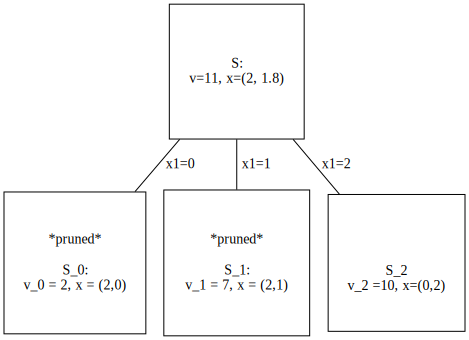

In [3]:
from graphviz import Graph

## https://www.graphviz.org/
## https://graphviz.readthedocs.io/en/stable/index.html

dot = Graph('bb1')

dot.node('S','S:\nv=11, x=(2, 1.8)',shape="square")

dot.node('S0','*pruned*\n\nS_0:\nv_0 = 2, x = (2,0)',shape="square")
dot.node('S1','*pruned*\n\nS_1:\nv_1 = 7, x = (2,1) ',shape="square")
dot.node('S2','\n\nS_2\nv_2 =10, x=(0,2)',shape="square")


dot.edge('S','S0','x1=0')
dot.edge('S','S1','x1=1')
dot.edge('S','S2','x1=2')

dot

Let's do one more slighlty more involved example with `branch-and-bound` "by hand".

## Manufacturing Example

**Problem:** Maximize $5x_1 + 4x_2$

**Subject to:**
- $x_1 + x_2 \leq 5$
- $10x_1 + 6x_2 \leq 45$
- $x_1, x_2 \geq 0$, integers

Let's represent it in `python`:

In [37]:

lp1 = {"goal": "max",
       "obj": np.array([5,4]),
       "Aub": np.array([[1,1],[10,6]]),
       "bub": np.array([5,45])
       }

In [39]:
get_optimal(lp1,[])

(23.75, array([3.75, 1.25]))

Both variables are fractional; we need to branch.

### Let's branch on $x_1$

we'll try all reasonable integer values for $x_1$.

In [42]:
for v in [0, 1, 2, 3, 4]:
    eq_constraint = [{"index": 0, "value": v}]
    result = get_optimal(lp1, eq_constraint)
    print(f"x1 = {v} --> {result}")

x1 = 0 --> (20.0, array([-0.,  5.]))
x1 = 1 --> (21.0, array([1., 4.]))
x1 = 2 --> (22.0, array([2., 3.]))
x1 = 3 --> (23.0, array([3., 2.]))
x1 = 4 --> (23.333333333333332, array([4.        , 0.83333333]))



**Best integer solution so far:** $(3, 2)$ with value $23$

**Key observation:** The $x_1 = 4$ case has upper bound $23.33 > 23$, so it might contain a better solution. We need to branch further.




### Step 3: Explore the $x_1 = 4$ case

Since $x_2 = 0.833...$ when $x_1 = 4$, try integer values for $x_2$:


In [45]:
for v in [0, 1]:
    eq_constraint = [{"index": 0, "value": 4}, {"index": 1, "value": v}]
    result = get_optimal(lp1, eq_constraint)
    print(f"x1 = 4, x2 = {v} --> {result}")

x1 = 4, x2 = 0 --> (20.0, array([ 4., -0.]))
x1 = 4, x2 = 1 --> lin program failed



Since $x_2$ must be an integer and $x_2 = 0$ gives value $20 < 23$, the entire $x_1 = 4$ branch cannot beat our current best.


### Conclusion

**Optimal integer solution:** $(x_1, x_2) = (3, 2)$ with value $= 23$


**Key lessons:**

- LP relaxation gave upper bound $23.75$, optimal integer is $23$
- Some integer combinations are infeasible even when the relaxation is feasible
- Systematic exploration ruled out all alternatives

Postcript
=========

It turns out that solving integer programming problems is pretty *hard*. In fact, in computer
science integer programming problems are in a class of problems called [**NP Hard** problems](https://en.wikipedia.org/wiki/NP-completeness) -- see the [discussion here.](https://en.wikipedia.org/wiki/Integer_programming).

The algorithm we describe above is a type of ``branch and bound algorithm``, which is a common approach. While our description gives pretty good evidence that this approach is effective, we haven't said anything e.g. about the ``run time`` of our algorithm, etc. (And actually, I'm not going to say more about this...but it is an interesting topic.)

# PuLP 
[https://pypi.org/project/PuLP/](https://pypi.org/project/PuLP/)

PuLP is an linear and mixed integer programming modeler written in Python.

Let's see it in action.

In [4]:
x=0
x+=3 # i.e. x= x+3
x

3

In [8]:
from pulp import *

# Create problem
prob = LpProblem("Manufacturing", LpMaximize)

# Variables (integers)
x1 = LpVariable("x1", lowBound=0, cat='Integer')
x2 = LpVariable("x2", lowBound=0, cat='Integer')

# Objective: maximize 5*x1 + 4*x2
prob += 5*x1 + 4*x2

# Constraints
prob += x1 + x2 <= 5
prob += 10*x1 + 6*x2 <= 45

# Solve
prob.solve(PULP_CBC_CMD(msg=0))
#prob.solve()

# Print solution
print(f"Status: {LpStatus[prob.status]}")
print(f"Optimal value: {value(prob.objective)}")
print(f"Solution: x1 = {value(x1)}, x2 = {value(x2)}")

Status: Optimal
Optimal value: 23.0
Solution: x1 = 3.0, x2 = 2.0


Notice the following

- We can give `PuLP` problems that have equality constraints, as well.

- We can declare some variables to be fractional and others to be integral

FOr example:


In [9]:
prob1 = LpProblem("test", LpMaximize)

x1 = LpVariable("x1", lowBound=0, cat='Integer')
x2 = LpVariable("x2", lowBound=0, cat='Integer')
x3 = LpVariable("x3", lowBound=0, cat='Continuous')

# Make x3 very valuable
prob1 += x1 + x2 + 10*x3

# Simple constraint that should force fractional x3
prob1 += x1 + x2 <= 10
prob1 += x1 >= 4
prob1 += x2 >= 4
prob1 += x1 + x2 + x3 <= 15.7  # Fractional upper bound

prob1.solve(PULP_CBC_CMD(msg=0))

print(f"Status: {LpStatus[prob1.status]}")
print(f"Optimal value: {value(prob1.objective)}")
print(f"Solution: x1 = {value(x1)}, x2 = {value(x2)}, x3 = {value(x3)}")

Status: Optimal
Optimal value: 85.0
Solution: x1 = 4.0, x2 = 4.0, x3 = 7.7


In [ ]:
d